<a href="https://colab.research.google.com/github/Tahahaha7/Capstone_Project/blob/master/Capstone_Road_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Constructing the road network}$

In [ ]:
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install momepy
!pip install osmapi

In [ ]:
%%capture
!pip install pandas==1.1.3

In [ ]:
%%capture
!pip install -Iv osmnx==0.16.0

In [ ]:
# Importing packages

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import osmnx as ox
import geopandas as gpd
import momepy
%matplotlib inline
ox.config(use_cache=True, log_console=True)
weight = 'length'

import warnings
#warnings.simplefilter(action="ignore", category='SettingWithCopyWarning')

ox.__version__, pd.__version__

('0.16.0', '1.1.3')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# changing the working directory
%cd /content/gdrive/My Drive/Capstone

/content/gdrive/My Drive/Capstone


In [ ]:
help(ox.graph_from_place)

In [ ]:
# Exrtact the entire road network of the city

%%time
road_network = ox.graph_from_place('London, UK', network_type='drive', simplify=True)
graph_nx = nx.relabel.convert_node_labels_to_integers(road_network)

CPU times: user 3min 31s, sys: 2.74 s, total: 3min 34s
Wall time: 3min 34s


In [ ]:
print(nx.info(graph_nx))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 297622
Average in degree:   2.3478
Average out degree:   2.3478


In [ ]:
nx.is_weakly_connected(graph_nx)

True

## $\text{Node Attributes}$

### $\text{IMD}$

In [ ]:
osm_nodes = pd.DataFrame([graph_nx.nodes(data=True)[node] for node in graph_nx.nodes])

In [ ]:
from shapely.geometry import Point, MultiPoint
osm_nodes['geometry'] = [Point(coor) for coor in list(zip(osm_nodes.x, osm_nodes.y))]
osm_nodes

,y,x,osmid,highway,ref,geometry
0,51.526976,-0.145792,78112,NaN,NaN,POINT (-0.1457924 51.526976)
1,51.523611,-0.152791,99936,NaN,NaN,POINT (-0.1527906 51.5236106)
2,51.523018,-0.152024,99937,NaN,NaN,POINT (-0.1520235 51.5230177)
3,51.535179,-0.148104,101818,NaN,NaN,POINT (-0.1481038 51.5351787)
4,51.535612,-0.147044,101831,NaN,NaN,POINT (-0.1470438 51.5356116)
...,...,...,...,...,...,...
126763,51.488857,-0.228561,8425816490,NaN,NaN,POINT (-0.228561 51.4888574)
126764,51.510827,-0.319952,8426996689,NaN,NaN,POINT (-0.3199518 51.5108275)
126765,51.510682,-0.319397,8426996692,NaN,NaN,POINT (-0.3193968 51.5106817)
126766,51.534836,0.013093,8429054706,NaN,NaN,POINT (0.0130934 51.5348358)


In [ ]:
# IMD DATA FOR EACH BOROUGH

link = 'https://data.london.gov.uk/download/indices-of-deprivation/9ee0cf66-e6f9-4e38-8eec-79c1d897e248/ID%202019%20for%20London.xlsx'

sheets = ['Notes', 'IMD 2019', 'Sub domains', 
          'IDACI and IDAOPI', 
          'Borough summary measures', 
          'Borough domain summaries', 
          'Borough IDACI IDAOPI',
          'Population figures',
          'Underlying indicators',
          'Underlying indicators notes']

imd_data = pd.read_excel(link, sheet_name=sheets[4])

In [ ]:
# Barnet is missing the geometry so it's added manually
barnet_imd = imd_data[imd_data['Local Authority District name (2019)'] == 'Barnet']['IMD - Average score ']

In [ ]:
# Extracting the shapely file of GBR (administrative area level)
import requests, zipfile, io
zip_file_url = 'http://biogeo.ucdavis.edu/data/diva/adm/GBR_adm.zip'
r = requests.get(zip_file_url)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall('/content/gdrive/My Drive/Capstone/geomerty')
GBR = geopandas.read_file('geomerty/GBR_adm2.shp')

london_shape = GBR[GBR.TYPE_2.isin(['London Borough','London Borough (city)','London Borough (royal)'])]
london_shape = london_shape.drop(labels=['ID_0','ISO','NAME_0','ID_1','NAME_1', 'NL_NAME_2', 'VARNAME_2'], axis=1)
london_shape = london_shape.replace('London', 'City of London')
imd_data = pd.merge(imd_data, london_shape, how='inner', left_on=['Local Authority District name (2019)'], right_on = ['NAME_2'])

<AxesSubplot:>

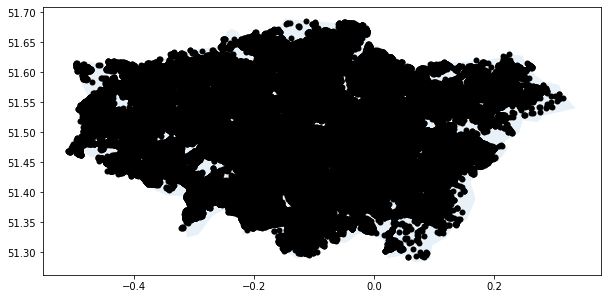

In [ ]:
base = geopandas.GeoDataFrame(imd_data).plot(alpha=.1, figsize=(10, 6));
geopandas.GeoDataFrame(osm_nodes).plot(ax=base, color='k', linewidth=.001)

In [ ]:
imd = [np.nan] * len(osm_nodes)

for id_point, point in enumerate(osm_nodes.geometry):
    for idx, borough in enumerate(imd_data.geometry):
        if borough.contains(point):
            imd[id_point] = imd_data['IMD - Average score '][idx]

In [ ]:
#imd = np.nan_to_num(imd, nan=barnet_imd)
#np.isnan(imd).sum(), len(imd)

#pd.DataFrame(imd).value_counts()

#np.savetxt('osm_nodes_imd.out', imd, delimiter=',')

#pd.DataFrame(np.loadtxt('osm_nodes_imd.out')).value_counts()

osm_nodes['imd'] = np.loadtxt('osm_nodes_imd.out')

### $\text{Ambulance Stations}$

In [ ]:
# Whether each node has ambulance station
# Ensure that 70 stations belong to 70 points

station_final = pd.read_csv('final_stations.csv')
station_final['geomerty'] = [Point(coor) for coor in list(zip(station_final.lng, station_final.lat))]

In [ ]:
station_final.head()

,Station/code,Address,Area,lat,lng,osm_id,geomerty
0,Barnehurst (L1),"164 Erith Road, Bexleyheath, Kent, DA7 6BZ",South Area,51.460780,0.153447,300944177,POINT (0.1534472 51.4607796)
1,Battersea (Q1),"119 Battersea Rise, London SW11 1HW",South Area,51.460499,-0.168533,183331810,POINT (-0.1685329 51.4604986)
2,Beckenham (M4),"12 Beckenham Road, Beckenham Kent BR3 4LR",South Area,51.408196,-0.036083,469787297,POINT (-0.03608280000000001 51.40819639999999)
3,Brixton (Q2),"Unit 25 Bessemer Park, 250 Milkwood Road, Lond...",South Area,51.458685,-0.102678,416184222,POINT (-0.102678 51.4586854)
4,Bromley (M1),"Crown Lane, Bromley Kent BR2 9PW",South Area,51.389395,0.037221,28476969,POINT (0.0372213 51.38939509999999)


In [ ]:
from shapely.ops import nearest_points
near = [nearest_points(station, MultiPoint(osm_nodes.geometry))[1], for station in station_final.geomerty]

In [ ]:
osm_nodes['station'] = [True if node in near else False for node in osm_nodes.geometry]

In [ ]:
#np.savetxt('osm_nodes_station.out', osm_nodes.station.values, delimiter=',')

osm_nodes['station'] = np.loadtxt('osm_nodes_station.out')

osm_nodes['station'] = osm_nodes['station'].astype(bool)

osm_nodes['station'].value_counts()

False    126698
True         70
Name: station, dtype: int64

In [ ]:
station_name = [np.nan]*len(osm_nodes); count = 0
for idx, i in enumerate(osm_nodes.station):
    if i: 
        station_name[idx] = station_final['Station/code'][count]
        count+=1

In [ ]:
osm_nodes['station_name'] = station_name

osm_nodes['station_name'].value_counts()

Wembley (C6)           1
St Helier (R1)         1
Woolwich (L5)          1
Brent (C3)             1
Chiswick (C2)          1
                      ..
West Ham (J2)          1
Isleworth (A2)         1
Ilford (K3)            1
Walthamstow (J4)       1
Nth Kensington (C4)    1
Name: station_name, Length: 70, dtype: int64

### $\text{Demographics}$

In [ ]:
df_london = pd.read_csv('demographics_london.csv')
df_london = geopandas.GeoDataFrame(df_london, geometry = geopandas.points_from_xy(df_london.Lon, df_london.Lat))

In [ ]:
df_london

,Lat,Lon,population,children,elderly,men,women,women_15_49,youth,geometry
0,51.63792,-0.04236,7.56437,0.66417,0.61174,3.37329,3.75781,2.20225,1.08365,POINT (-0.04236 51.63792)
1,51.63903,-0.04236,7.56437,0.66417,0.61174,3.37329,3.75781,2.20225,1.08365,POINT (-0.04236 51.63903)
2,51.58514,-0.03236,14.13992,1.35346,1.25678,6.91229,6.18723,4.20538,1.64348,POINT (-0.03236 51.58514)
3,51.63875,-0.05514,4.65067,0.37904,0.98552,2.02158,2.36272,0.92234,0.45485,POINT (-0.05514 51.63875)
4,51.62403,-0.05569,7.76460,0.67116,1.00674,3.41874,3.90114,2.01349,0.90188,POINT (-0.05569 51.62403)
...,...,...,...,...,...,...,...,...,...,...
1042662,51.49014,-0.20792,43.81536,1.44852,1.86239,20.27934,21.72786,17.79615,9.10501,POINT (-0.20792 51.49014)
1042663,51.59903,0.23014,3.66521,0.18491,1.24815,1.67961,1.91075,0.69342,0.38523,POINT (0.23014 51.59903)
1042664,51.59736,0.23069,3.66521,0.18491,1.24815,1.67961,1.91075,0.69342,0.38523,POINT (0.23069 51.59736)
1042665,51.59903,0.23125,3.66521,0.18491,1.24815,1.67961,1.91075,0.69342,0.38523,POINT (0.23125 51.59903)


In [ ]:
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=5):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

In [ ]:
closest_stops = nearest_neighbor(osm_nodes, df_london)

In [ ]:
closest_stops

,Lat,Lon,population,children,elderly,men,women,women_15_49,youth,geometry
0,51.52708,-0.14569,5.91539,0.18449,1.77573,2.74432,2.90574,1.31450,0.50735,POINT (-0.14569 51.52708)
1,51.52375,-0.15292,9.98400,0.55808,2.87626,4.33585,4.80807,2.06060,0.77273,POINT (-0.15292 51.52375)
2,51.52292,-0.15208,8.20282,0.61328,0.80492,4.13961,3.37301,2.41477,0.84325,POINT (-0.15208 51.52292)
3,51.53514,-0.14764,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240,POINT (-0.14764 51.53514)
4,51.53569,-0.14708,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240,POINT (-0.14708 51.53569)
...,...,...,...,...,...,...,...,...,...,...
126763,51.48903,-0.22875,60.16519,4.13864,7.50128,26.38383,31.29847,20.17587,11.63992,POINT (-0.22875 51.48903)
126764,51.51097,-0.32014,11.44771,0.66807,1.12236,5.55836,5.31786,3.39381,0.82841,POINT (-0.32014 51.51097)
126765,51.51069,-0.31903,10.01886,0.74112,0.71796,4.93305,4.58565,3.12658,1.01903,POINT (-0.31903 51.51069)
126766,51.53486,0.01319,21.91588,1.09164,3.27493,10.12250,9.52706,4.91239,3.17569,POINT (0.01319 51.53486)


In [ ]:
osm_nodes

,y,x,osmid,highway,ref,geometry,station,station_name,imd
0,51.526976,-0.145792,78112,NaN,NaN,POINT (-0.14579 51.52698),False,NaN,20.339
1,51.523611,-0.152791,99936,NaN,NaN,POINT (-0.15279 51.52361),False,NaN,20.339
2,51.523018,-0.152024,99937,NaN,NaN,POINT (-0.15202 51.52302),False,NaN,20.339
3,51.535179,-0.148104,101818,NaN,NaN,POINT (-0.14810 51.53518),False,NaN,20.131
4,51.535612,-0.147044,101831,NaN,NaN,POINT (-0.14704 51.53561),False,NaN,20.131
...,...,...,...,...,...,...,...,...,...
126763,51.488857,-0.228561,8425816490,NaN,NaN,POINT (-0.22856 51.48886),False,NaN,22.270
126764,51.510827,-0.319952,8426996689,NaN,NaN,POINT (-0.31995 51.51083),False,NaN,22.710
126765,51.510682,-0.319397,8426996692,NaN,NaN,POINT (-0.31940 51.51068),False,NaN,22.710
126766,51.534836,0.013093,8429054706,NaN,NaN,POINT (0.01309 51.53484),False,NaN,29.577


In [ ]:
final_osm_nodes = pd.merge(osm_nodes.drop(columns=['highway', 'ref']), 
                           closest_stops.drop(columns=['Lat', 'Lon', 'geometry']), 
                           left_index=True, right_index=True)

In [ ]:
final_osm_nodes

,y,x,osmid,geometry,station,station_name,imd,population,children,elderly,men,women,women_15_49,youth
0,51.526976,-0.145792,78112,POINT (-0.14579 51.52698),False,NaN,20.339,5.91539,0.18449,1.77573,2.74432,2.90574,1.31450,0.50735
1,51.523611,-0.152791,99936,POINT (-0.15279 51.52361),False,NaN,20.339,9.98400,0.55808,2.87626,4.33585,4.80807,2.06060,0.77273
2,51.523018,-0.152024,99937,POINT (-0.15202 51.52302),False,NaN,20.339,8.20282,0.61328,0.80492,4.13961,3.37301,2.41477,0.84325
3,51.535179,-0.148104,101818,POINT (-0.14810 51.53518),False,NaN,20.131,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240
4,51.535612,-0.147044,101831,POINT (-0.14704 51.53561),False,NaN,20.131,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126763,51.488857,-0.228561,8425816490,POINT (-0.22856 51.48886),False,NaN,22.270,60.16519,4.13864,7.50128,26.38383,31.29847,20.17587,11.63992
126764,51.510827,-0.319952,8426996689,POINT (-0.31995 51.51083),False,NaN,22.710,11.44771,0.66807,1.12236,5.55836,5.31786,3.39381,0.82841
126765,51.510682,-0.319397,8426996692,POINT (-0.31940 51.51068),False,NaN,22.710,10.01886,0.74112,0.71796,4.93305,4.58565,3.12658,1.01903
126766,51.534836,0.013093,8429054706,POINT (0.01309 51.53484),False,NaN,29.577,21.91588,1.09164,3.27493,10.12250,9.52706,4.91239,3.17569


In [ ]:
## WORKS JUST FINE WITH GPKG (something is off with the settings of gpkg)

final_osm_nodes.to_csv('final_osm_nodes.csv', index=False)
#final_osm_nodes = gpd.read_file("final_osm_nodes.gpkg", driver="GPKG")

In [ ]:
final_osm_nodes.columns

Index(['y', 'x', 'osmid', 'geometry', 'station', 'station_name', 'imd',
       'population', 'children', 'elderly', 'men', 'women', 'women_15_49',
       'youth'],
      dtype='object')

In [ ]:
final_osm_nodes.dtypes

y               float64
x               float64
osmid             int64
imd             float64
station            bool
population      float64
children        float64
elderly         float64
men             float64
women           float64
women_15_49     float64
youth           float64
geometry       geometry
dtype: object

## $\text{Edge Attributes}$

In [ ]:
osm_edges = pd.DataFrame(graph_nx.edges(data=True), columns=['source_idx', 'target_idx', 'info'])

osm_edges_info = pd.DataFrame(osm_edges['info'].values.tolist(), index=osm_edges.index)

osm_edges_info.insert(0, 'target_idx', osm_edges.target_idx)
osm_edges_info.insert(0, 'source_idx', osm_edges.source_idx)

In [ ]:
osm_edges_info

In [ ]:
osm_edges_info = osm_edges_info.drop(columns=['osmid', 'access', 'lanes', 'ref', 'bridge', 'junction', 'tunnel', 'width', 'est_width', 'service', 'area'])

In [ ]:
#osm_edges_info.head()
osm_edges_info.columns

Index(['source_idx', 'target_idx', 'name', 'highway', 'oneway', 'length',
       'maxspeed', 'geometry'],
      dtype='object')

In [ ]:
# Empty the MAXSPEED from nested lists and turn it into int

maxspeed = []
for i in osm_edges_info.maxspeed:
    if not isinstance(i, list): 
        if type(i) == str:
            try: maxspeed.append(int(' '.join(filter(str.isdigit, i))))
            except: maxspeed.append(np.nan)
        else: maxspeed.append(i)
    elif isinstance(i, list):
        if i[0]!='signals': maxspeed.append(i[0])
        else: maxspeed.append(i[1])

osm_edges_info['maxspeed'] = maxspeed
osm_edges_info['maxspeed'] = osm_edges_info['maxspeed'].fillna(20)

In [ ]:
osm_edges_info.maxspeed.value_counts()

20.0    241058
30.0     52764
40.0      2315
50.0       790
5.0        269
10.0       177
70.0       117
60.0        61
15.0        52
12.0        10
25.0         4
7.0          2
64.0         2
2.0          1
Name: maxspeed, dtype: int64

In [ ]:
# Attach all the NAMES of roads

name = []
for idx, i in enumerate(osm_edges_info.name):
    if not isinstance(i, list): name.append(i)
    if isinstance(i, list):
        name.append(' '.join(i))

osm_edges_info['name'] = name

In [ ]:
# Take on value of the HIGHWAY of type

highway = []
for idx, i in enumerate(osm_edges_info.highway):
    if not isinstance(i, list): highway.append(i)
    if isinstance(i, list):
        highway.append(i[0])

osm_edges_info['highway'] = highway

In [ ]:
# Check if dataframe has nested lists
def count(l): return sum(1+count(i) for i in l if isinstance(i, list))

[count(osm_edges_info[column]) for column in osm_edges_info.columns]

[0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
final_osm_edges = pd.merge(osm_edges_info, 
                           final_osm_nodes[['x', 'y', 'osmid']].rename(columns={"y": "y_source", "x": "x_source", "osmid": "osmid_source"}),
                           how='left',
                           left_on='source_idx',
                           right_on=final_osm_nodes.index)

In [ ]:
final_osm_edges = pd.merge(final_osm_edges,
                           final_osm_nodes[['x', 'y', 'osmid']].rename(columns={"y": "y_target", "x": "x_target", "osmid": "osmid_target"}),
                           how='left',
                           left_on='target_idx',
                           right_on=final_osm_nodes.index)

In [ ]:
assert(len(final_osm_edges) == 297622)

In [ ]:
final_osm_edges.columns

Index(['source_idx', 'target_idx', 'name', 'highway', 'oneway', 'length',
       'maxspeed', 'geometry', 'x_source', 'y_source', 'osmid_source',
       'x_target', 'y_target', 'osmid_target'],
      dtype='object')

In [ ]:
final_osm_edges.isna().sum()

source_idx           0
target_idx           0
name             16011
highway              0
oneway               0
length               0
maxspeed             0
geometry        106849
x_source             0
y_source             0
osmid_source         0
x_target             0
y_target             0
osmid_target         0
dtype: int64

In [ ]:
# Importing Uber Speed Data

#filename_2019_Q1 = "london_2019_Q1.geojson"
filename_jan_2019 = "london_jan_2019.geojson"
#file = open(filename)

df_uber = geopandas.read_file(filename_jan_2019)

In [ ]:
[count(df_uber[column]) for column in df_uber.columns]

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df_uber.isna().sum()

osmname                428084
osmstartnodeid              0
osmhighway                  0
osmendnodeid                0
osmwayid                    0
speed_mean_mph        1057406
pct_from_freeflow     1057406
speed_freeflow_mph    1057406
geometry                    0
dtype: int64

In [ ]:
#df_uber['source_target'] = list(zip(df_uber.osmstartnodeid, df_uber.osmendnodeid))
#final_osm_edges['source_target'] = list(zip(final_osm_edges.osmid_source, final_osm_edges.osmid_target))
#uber_osm = uber_osm.drop(columns=['source_target'])

In [ ]:
# Merge UBER with OSM from start to end

uber_osm = pd.merge(final_osm_edges, df_uber.drop(columns=['osmname']).dropna().reset_index(),
                    how='left',
                    left_on = ['osmid_source', 'osmid_target'],
                    right_on = ['osmstartnodeid', 'osmendnodeid'])

In [ ]:
len(uber_osm) # 297638

297638

In [ ]:
uber_osm.columns

Index(['source_idx', 'target_idx', 'name', 'highway', 'oneway', 'length',
       'maxspeed', 'geometry_x', 'x_source', 'y_source', 'osmid_source',
       'x_target', 'y_target', 'osmid_target', 'index', 'osmstartnodeid',
       'osmhighway', 'osmendnodeid', 'osmwayid', 'speed_mean_mph',
       'pct_from_freeflow', 'speed_freeflow_mph', 'geometry_y'],
      dtype='object')

In [ ]:
# Intersection of geometries from Uber and OSM
uber_osm['geometry'] = uber_osm['geometry_x'].fillna(uber_osm['geometry_y'])

In [ ]:
uber_osm = uber_osm.drop(columns=['geometry_x', 'geometry_y'])

In [ ]:
uber_osm.isna().sum()

source_idx                 0
target_idx                 0
name                   16014
highway                    0
oneway                     0
length                     0
maxspeed                   0
x_source                   0
y_source                   0
osmid_source               0
x_target                   0
y_target                   0
osmid_target               0
index                 224504
osmstartnodeid        224504
osmhighway            224504
osmendnodeid          224504
osmwayid              224504
speed_mean_mph        224504
pct_from_freeflow     224504
speed_freeflow_mph    224504
geometry               78678
dtype: int64

In [ ]:
uber_osm.maxspeed.value_counts()

20.0    241072
30.0     52765
40.0      2316
50.0       790
5.0        269
10.0       177
70.0       117
60.0        61
15.0        52
12.0        10
25.0         4
7.0          2
64.0         2
2.0          1
Name: maxspeed, dtype: int64

In [ ]:
Graph = nx.from_pandas_edgelist(uber_osm, 
                                source='osmid_source', 
                                target='osmid_target', 
                                create_using=nx.MultiDiGraph(), 
                                edge_attr=['name', 'length', 'maxspeed', 'speed_mean_mph',
                                           'pct_from_freeflow', 'speed_freeflow_mph', 
                                           'geometry'])

print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 297638
Average in degree:   2.3479
Average out degree:   2.3479


In [ ]:
nx.is_weakly_connected(Graph)

True

In [ ]:
uber_osm.dtypes

source_idx              int64
target_idx              int64
name                   object
highway                object
oneway                   bool
length                float64
maxspeed               object
x_source              float64
y_source              float64
osmid_source            int64
x_target              float64
y_target              float64
osmid_target            int64
index                 float64
osmstartnodeid        float64
osmhighway             object
osmendnodeid          float64
osmwayid              float64
speed_mean_mph        float64
pct_from_freeflow     float64
speed_freeflow_mph    float64
geometry               object
dtype: object

In [ ]:
geopandas.GeoDataFrame(uber_osm).to_file("uber_osm.gpkg", driver="GPKG")

In [ ]:
uber_osm.to_csv('uber_osm.csv', index=False)

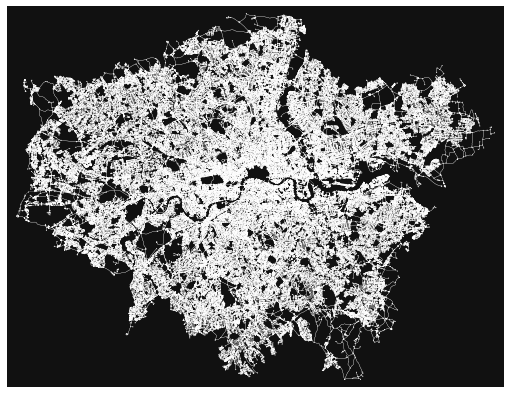

In [ ]:
fig, ax = ox.plot_graph(road_network, node_size=1, edge_color='w', edge_linewidth=0.2, figsize=(15, 10))

# IGNORE THE REST

In [ ]:
len(final_osm_edges) - len(uber_osm)

-3131

In [ ]:
#final_osm_edges['source_target'] = list(zip(final_osm_edges.osmid_source, final_osm_edges.osmid_target))
#final_osm_edges[final_osm_edges.duplicated(subset=['source_target'], keep='first')]
#df.duplicated(subset=['osmstartnodeid', 'osmendnodeid']).sum()

In [ ]:
final_osm_edges.columns, df.columns

(Index(['source_idx', 'target_idx', 'osmid', 'name', 'highway', 'access',
        'oneway', 'length', 'maxspeed', 'geometry', 'lanes', 'ref', 'bridge',
        'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
        'x_source', 'y_source', 'osmid_source', 'x_target', 'y_target',
        'osmid_target'],
       dtype='object'),
 Index(['osmname', 'osmstartnodeid', 'osmhighway', 'osmendnodeid', 'osmwayid',
        'speed_mean_mph', 'pct_from_freeflow', 'speed_freeflow_mph',
        'geometry'],
       dtype='object'))

In [ ]:
# Merge Uber with osm from start to end

uber_osm = pd.merge(final_osm_edges, df,
                    how='left',
                    left_on = ['osmid_source', 'osmid_target'],
                    right_on = ['osmstartnodeid', 'osmendnodeid'])

In [ ]:
#uber_osm.columns
#uber_osm.duplicated(subset=['source_idx', 'target_idx'], keep=False).sum()

9953

In [ ]:
len(uber_osm)

300753

In [ ]:
uber_osm = uber_osm.rename(columns={'geometry_y':'geometry'})

In [ ]:
type(uber_osm)

pandas.core.frame.DataFrame

In [ ]:
uber_osm.isna().sum()

source_idx                 0
target_idx                 0
osmid                      0
name                   16330
highway                    0
access                299102
oneway                     0
length                     0
maxspeed               96311
geometry_x            107541
lanes                 273828
ref                   254703
bridge                297953
junction              297044
tunnel                300256
width                 300573
est_width             300731
service               300732
area                  300744
x_source                   0
y_source                   0
osmid_source               0
x_target                   0
y_target                   0
osmid_target               0
osmname                82923
osmstartnodeid         69682
osmhighway             69682
osmendnodeid           69682
osmwayid               69682
speed_mean_mph        227619
pct_from_freeflow     227619
speed_freeflow_mph    227619
geometry               69682
dtype: int64

In [ ]:
#geopandas.GeoDataFrame(final_osm_nodes).to_file("final_osm_nodes.gpkg", driver="GPKG")

In [ ]:
#geopandas.GeoDataFrame(final_osm_edges).to_file("final_osm_edges.gpkg", driver="GPKG")
final_osm_edges.columns

Index(['source_idx', 'target_idx', 'osmid', 'name', 'highway', 'access',
       'oneway', 'length', 'maxspeed', 'geometry', 'lanes', 'ref', 'bridge',
       'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
       'x_source', 'y_source', 'osmid_source', 'x_target', 'y_target',
       'osmid_target'],
      dtype='object')

In [ ]:
#final_osm_edges[['length', 'maxspeed', 'speed_mean_mph', 'pct_from_freeflow', 'speed_freeflow_mph', 'geometry']]
final_osm_edges

In [ ]:
#[count(final_osm_edges[column]) for column in final_osm_edges.columns]

#geopandas.GeoDataFrame(uber_osm).to_file("final_osm_nodes.gpkg", driver="GPKG")

In [ ]:
Graph = nx.from_pandas_edgelist(uber_osm, source='osmid_source', 
                                target='osmid_target', create_using=nx.MultiDiGraph(), 
                                edge_attr=['osmid', 'length', 'maxspeed', 'speed_mean_mph',  'pct_from_freeflow', 
                                           'speed_freeflow_mph', 'geometry'])

print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 300753
Average in degree:   2.3725
Average out degree:   2.3725


In [ ]:
nx.is_weakly_connected(Graph)

True

In [ ]:
final_osm_nodes.head()

,y,x,osmid,geometry,imd,station,population,children,elderly,men,women,women_15_49,youth
0,51.526976,-0.145792,78112,POINT (-0.14579 51.52698),20.339,False,5.91539,0.18449,1.77573,2.74432,2.90574,1.31450,0.50735
1,51.523611,-0.152791,99936,POINT (-0.15279 51.52361),20.339,False,9.98400,0.55808,2.87626,4.33585,4.80807,2.06060,0.77273
2,51.523018,-0.152024,99937,POINT (-0.15202 51.52302),20.339,False,8.20282,0.61328,0.80492,4.13961,3.37301,2.41477,0.84325
3,51.535179,-0.148104,101818,POINT (-0.14810 51.53518),20.131,False,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240
4,51.535612,-0.147044,101831,POINT (-0.14704 51.53561),20.131,False,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240


In [ ]:
dict_osm = {x: {'position': (a, b), 'imd': c, 'station': d, 
                'population':e, 'children':f, 'elderly':g,
                'men':h, 'women':i, 'women_15_49':j, 'youth':k}
            for x, a, b, c, d, e, f, g, h, i, j, k in zip(final_osm_nodes.osmid, final_osm_nodes.x, 
                                                          final_osm_nodes.y, final_osm_nodes.imd, 
                                                          final_osm_nodes.station, final_osm_nodes.population, 
                                                          final_osm_nodes.children, final_osm_nodes.elderly, 
                                                          final_osm_nodes.men, final_osm_nodes.women, 
                                                          final_osm_nodes.women_15_49, final_osm_nodes.youth)}

nx.set_node_attributes(Graph, dict_osm)

In [ ]:
list(Graph.nodes(data=True))[0]

(78112,
 {'children': 0.18449000000000002,
  'elderly': 1.77573,
  'imd': 20.339,
  'men': 2.74432,
  'population': 5.91539,
  'position': (-0.1457924, 51.526976),
  'station': False,
  'women': 2.90574,
  'women_15_49': 1.3145,
  'youth': 0.50735})

In [ ]:
list(Graph.edges(data=True))[0]

(78112,
 25508583,
 {'geometry': <shapely.geometry.linestring.LineString at 0x7efc7ed19d90>,
  'highway': 'unclassified',
  'length': 19.391,
  'maxspeed': nan,
  'osmid': 129375498,
  'pct_from_freeflow': -11.0,
  'speed_freeflow_mph': 32.0,
  'speed_mean_mph': 28.0})

In [ ]:
uber_osm.isna().sum()

source_idx                 0
target_idx                 0
osmid                      0
name                   16330
highway                    0
access                299102
oneway                     0
length                     0
maxspeed               96311
geometry_x            107541
lanes                 273828
ref                   254703
bridge                297953
junction              297044
tunnel                300256
width                 300573
est_width             300731
service               300732
area                  300744
x_source                   0
y_source                   0
osmid_source               0
x_target                   0
y_target                   0
osmid_target               0
osmname                82923
osmstartnodeid         69682
osmhighway             69682
osmendnodeid           69682
osmwayid               69682
speed_mean_mph        227619
pct_from_freeflow     227619
speed_freeflow_mph    227619
geometry               69682
dtype: int64

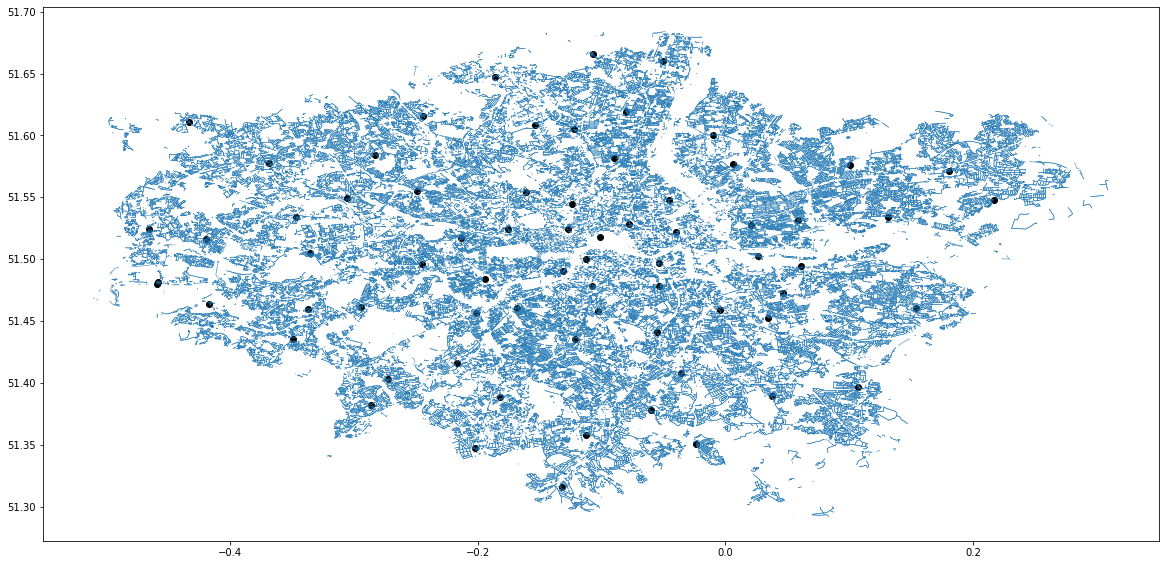

In [ ]:
base = stations.plot(color='k', figsize=(20, 10));
geopandas.GeoDataFrame(uber_osm).plot(ax=base, 
                                      #column='length', 
                                      #cmap='coolwarm_r', 
                                      #legend=True,
                                      linewidth=.1);

# $\text{Geographical Positions}$

In [ ]:
%%time
uber_osm = pd.read_csv('uber_osm.csv')
uber_osm = geopandas.GeoDataFrame(uber_osm)

CPU times: user 1.65 s, sys: 222 ms, total: 1.87 s
Wall time: 1.97 s


<string>:2: DtypeWarning: Columns (15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
uber_osm.columns

Index(['source_idx', 'target_idx', 'osmid', 'name', 'highway', 'access',
       'oneway', 'length', 'maxspeed', 'geometry_x', 'lanes', 'ref', 'bridge',
       'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
       'y_source', 'x_source', 'osmid_source', 'y_target', 'x_traget',
       'osmid_target', 'osmname', 'osmstartnodeid', 'osmhighway',
       'osmendnodeid', 'osmwayid', 'speed_mean_mph', 'pct_from_freeflow',
       'speed_freeflow_mph', 'geometry'],
      dtype='object')

In [ ]:
uber_osm.isna().sum()

## $\text{Drawing the network}$

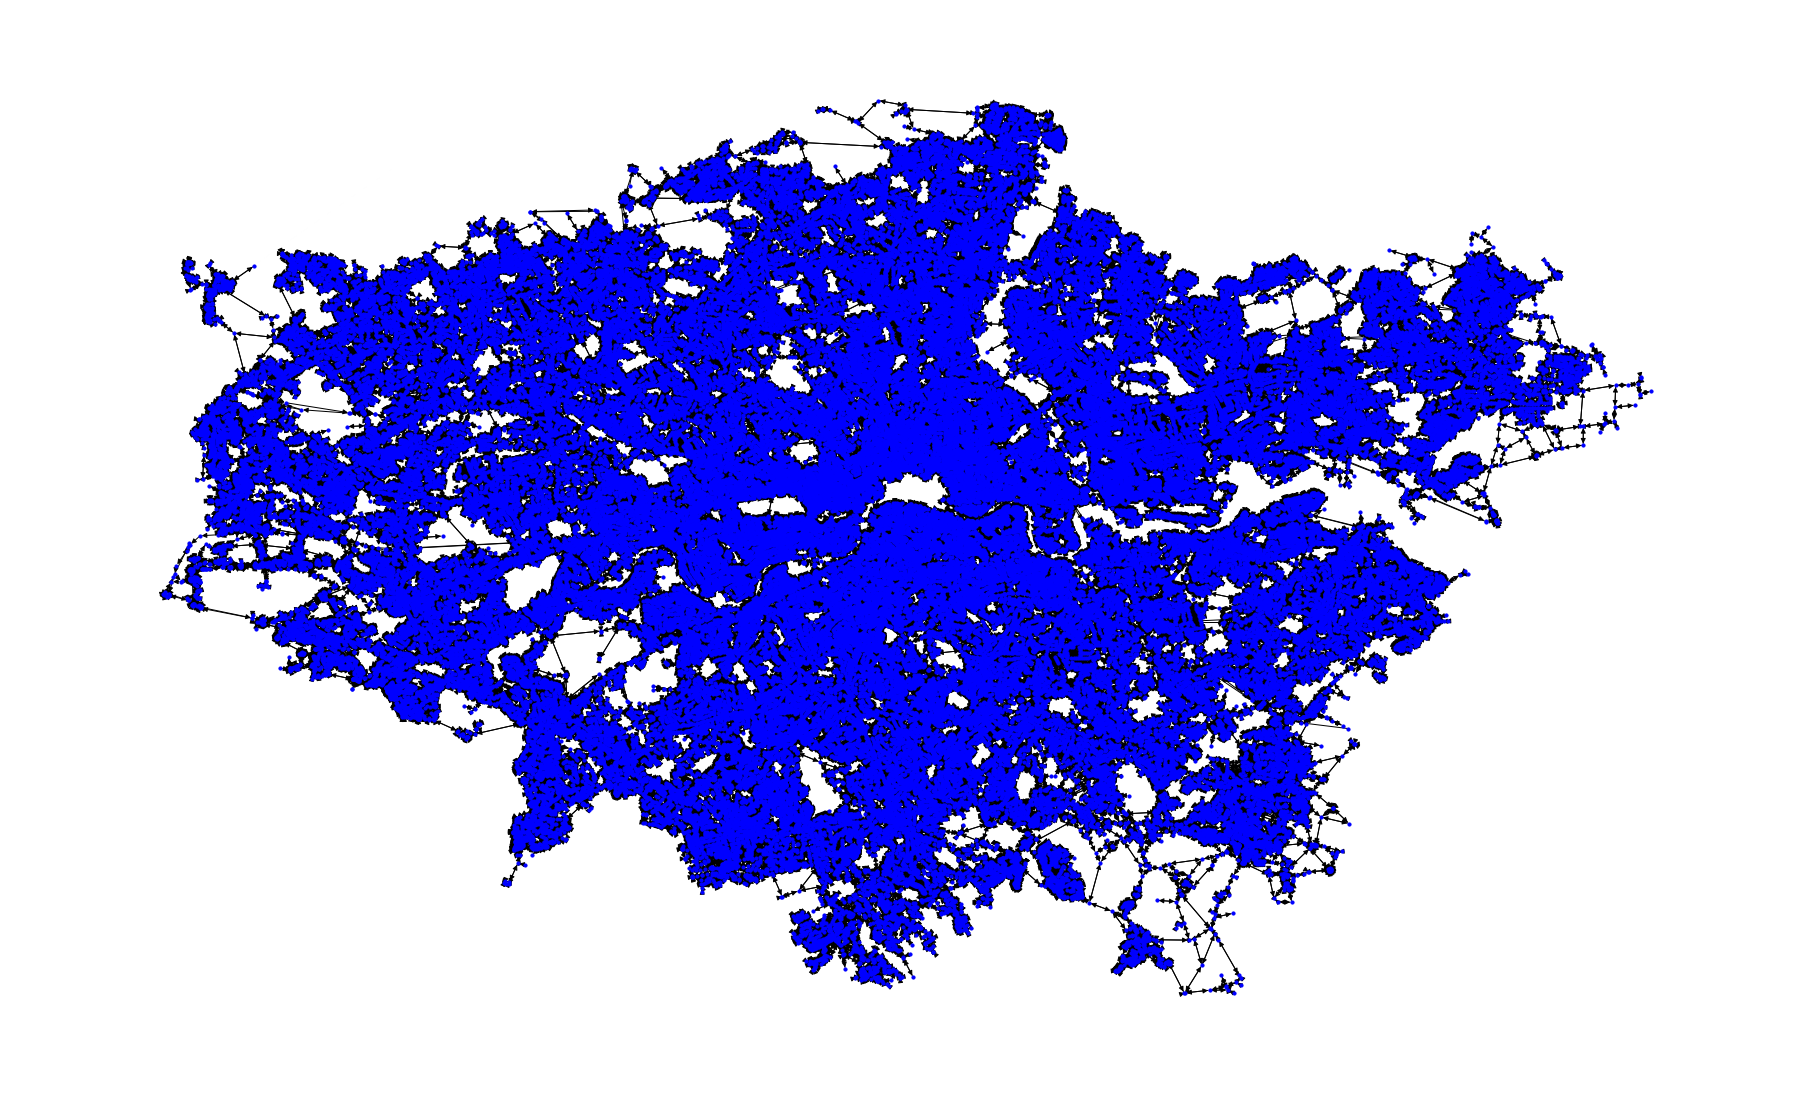

In [ ]:
# Relabeling nodes just to draw
Graph = nx.relabel_nodes(Graph, dict(zip(Graph.nodes, range(len(Graph.nodes)))))

plt.figure(figsize=(25, 15))
nx.draw(Graph, pos = [Graph.nodes[i]['position'] for i in Graph.nodes],
        node_size=10, node_color = 'blue', with_labels=False)
plt.show()

# $\text{IMD stats}$

In [ ]:
london_shape = GBR[GBR.TYPE_2.isin(['London Borough','London Borough (city)','London Borough (royal)'])]
london_shape = london_shape.drop(labels=['ID_0','ISO','NAME_0','ID_1','NAME_1', 'NL_NAME_2', 'VARNAME_2'], axis=1)
london_shape = london_shape.replace('London', 'City of London')

imd_data = pd.merge(imd_data, london_shape, how='inner', left_on=['Local Authority District name (2019)'], right_on = ['NAME_2'])

In [ ]:
imd_data = geopandas.GeoDataFrame(imd_data)

In [ ]:
#from shapely.geometry import Point
from shapely import wkt

#uber_osm['geometry'] = uber_osm.geometry.apply(wkt.loads)
#uber_osm['geometry'] = uber_osm.geometry.apply(lambda x: wkt.load() if(pd.notnull(x)) else x)

uber_osm['geometry'] = uber_osm['geometry'].apply(wkt.loads)
uber_osm = geopandas.GeoDataFrame(uber_osm, geometry='geometry')

In [ ]:
for idx, borough in enumerate(imd_data.geometry):
    if borough.contains(Point(list(Graph.nodes(data=True))[0][1]['position'])):
        print('point inside {} and score {}'.format(imd_data['Local Authority District name (2019)'][idx],
                                       imd_data['IMD - Average score '][idx]))

point inside Westminster and score 20.339


# $\text{Ambulance Stations}$

# $\text{Demographics}$